# W07 F Activity 1: Challenge

DS 2023 | Communicating with Data

Extract a graph from a tidy table and display it.

## Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig

## Get Data

In [2]:
data_file = "cfb_box-scores_2002-2024.csv"
df = pd.read_csv(data_file)
acc = df[(df["conf_home"] == "acc") | (df["conf_away"] == "acc")]

## Define Functions

In [3]:
def tidy_to_graph(df:pd.DataFrame, node_cols:list):
    """
    Converts columns from a tidy table into a graph comprised of NODES and EDGES data frames.

    Works for bipartite graphs -- graphs with connections between two columns.
    """

    # Create nodes
    NODES = df[node_cols].melt().value_counts().to_frame('n')
    NODES.index.names = ['type', 'label']
    NODES = NODES.reset_index()
    NODES.index.name = 'id'

    # Create edges
    EDGES = df[node_cols].value_counts().to_frame('n').reset_index()
    EDGES.index.name = 'id'

    # Function to replace node names with node ids in the EDGES data frame
    def replace_names_with_ids(col_name):
        # Temporary NODES table the selected nodes for column name and swaps the index to label        
        X = NODES[NODES.type == col_name].reset_index().set_index('label')
        # Replaces column value with id using .map()
        EDGES[col_name] = EDGES[col_name].map(X.id)

    # Replace names with ids in EDGES
    for col in node_cols:
        replace_names_with_ids(col)

    # Renames EDGES columns
    EDGES.columns = ['source', 'target', 'n']

    # Returns both data frames
    return NODES, EDGES


In [4]:
def graph_to_igraph(NODES:pd.DataFrame, EDGES:pd.DataFrame, directed:bool=False):
    """
    Converts NODES and EDGES directly into an igraph Graph object.
        """
    # Create graph from EDGES
    g = ig.Graph(edges=EDGES[['source', 'target']].values.tolist())
        
    # Add vertex (node) attributes
    g.vs['label'] = NODES['label'].to_list() # [NODES.loc[i, 'label'] for i in range(len(NODES))]
    g.vs['count'] = NODES['n'].to_list() # [NODES.loc[i, 'n'] for i in range(len(NODES))]
    g.vs['node_type'] = NODES['type'].to_list() # [NODES.loc[i, 'type'] for i in range(len(NODES))]
        
    # Add edge attributes
    g.es['weight'] = EDGES['n'].tolist()    
    
    return g

In [5]:
def graphplot(my_g, node_cols, layout_type='rt_circular', sized=False, title=None, figsize=(20,20)):
    
    if sized: 
        egde_weight = pd.Series(my_g.es['weight'])
        node_count = pd.Series(my_g.vs['count'])
        e_w = (egde_weight / egde_weight.sum()) * 100
        v_s = (node_count / node_count.sum()) * 500
    else:
        e_w = None
        v_s = None
    
    fig, ax = plt.subplots(figsize=figsize)
    ig.plot(
        my_g,
        target = ax,
        layout = layout_type,
        edge_width = e_w, 
        vertex_size = v_s, 
        vertex_color =["#ccff99" if type == node_cols[0] else "#ffcc99" for type in my_g.vs["node_type"]],    
        vertex_frame_width = 1.0,
        vertex_frame_color = "gray",
        vertex_label = my_g.vs["label"],
        vertex_label_size = 12.0,
    )
    plt.title(title, fontsize=20)
    plt.show()

## Tasks

### Task 1

Extract node and edge data frames from the NCAA football data set. 

Select only rows where either the home or away team is in the ACC.

Use `home` and `away` as your node columms.

In [6]:
nodes, edges = tidy_to_graph(acc, ["home", "away"])

### Task 2

Create a graph object from these data frames.

In [7]:
g = graph_to_igraph(nodes, edges)

### Task 3

Plot the graph object. Try visualizing with `sized = False` (the default) and as `sized = True`. 

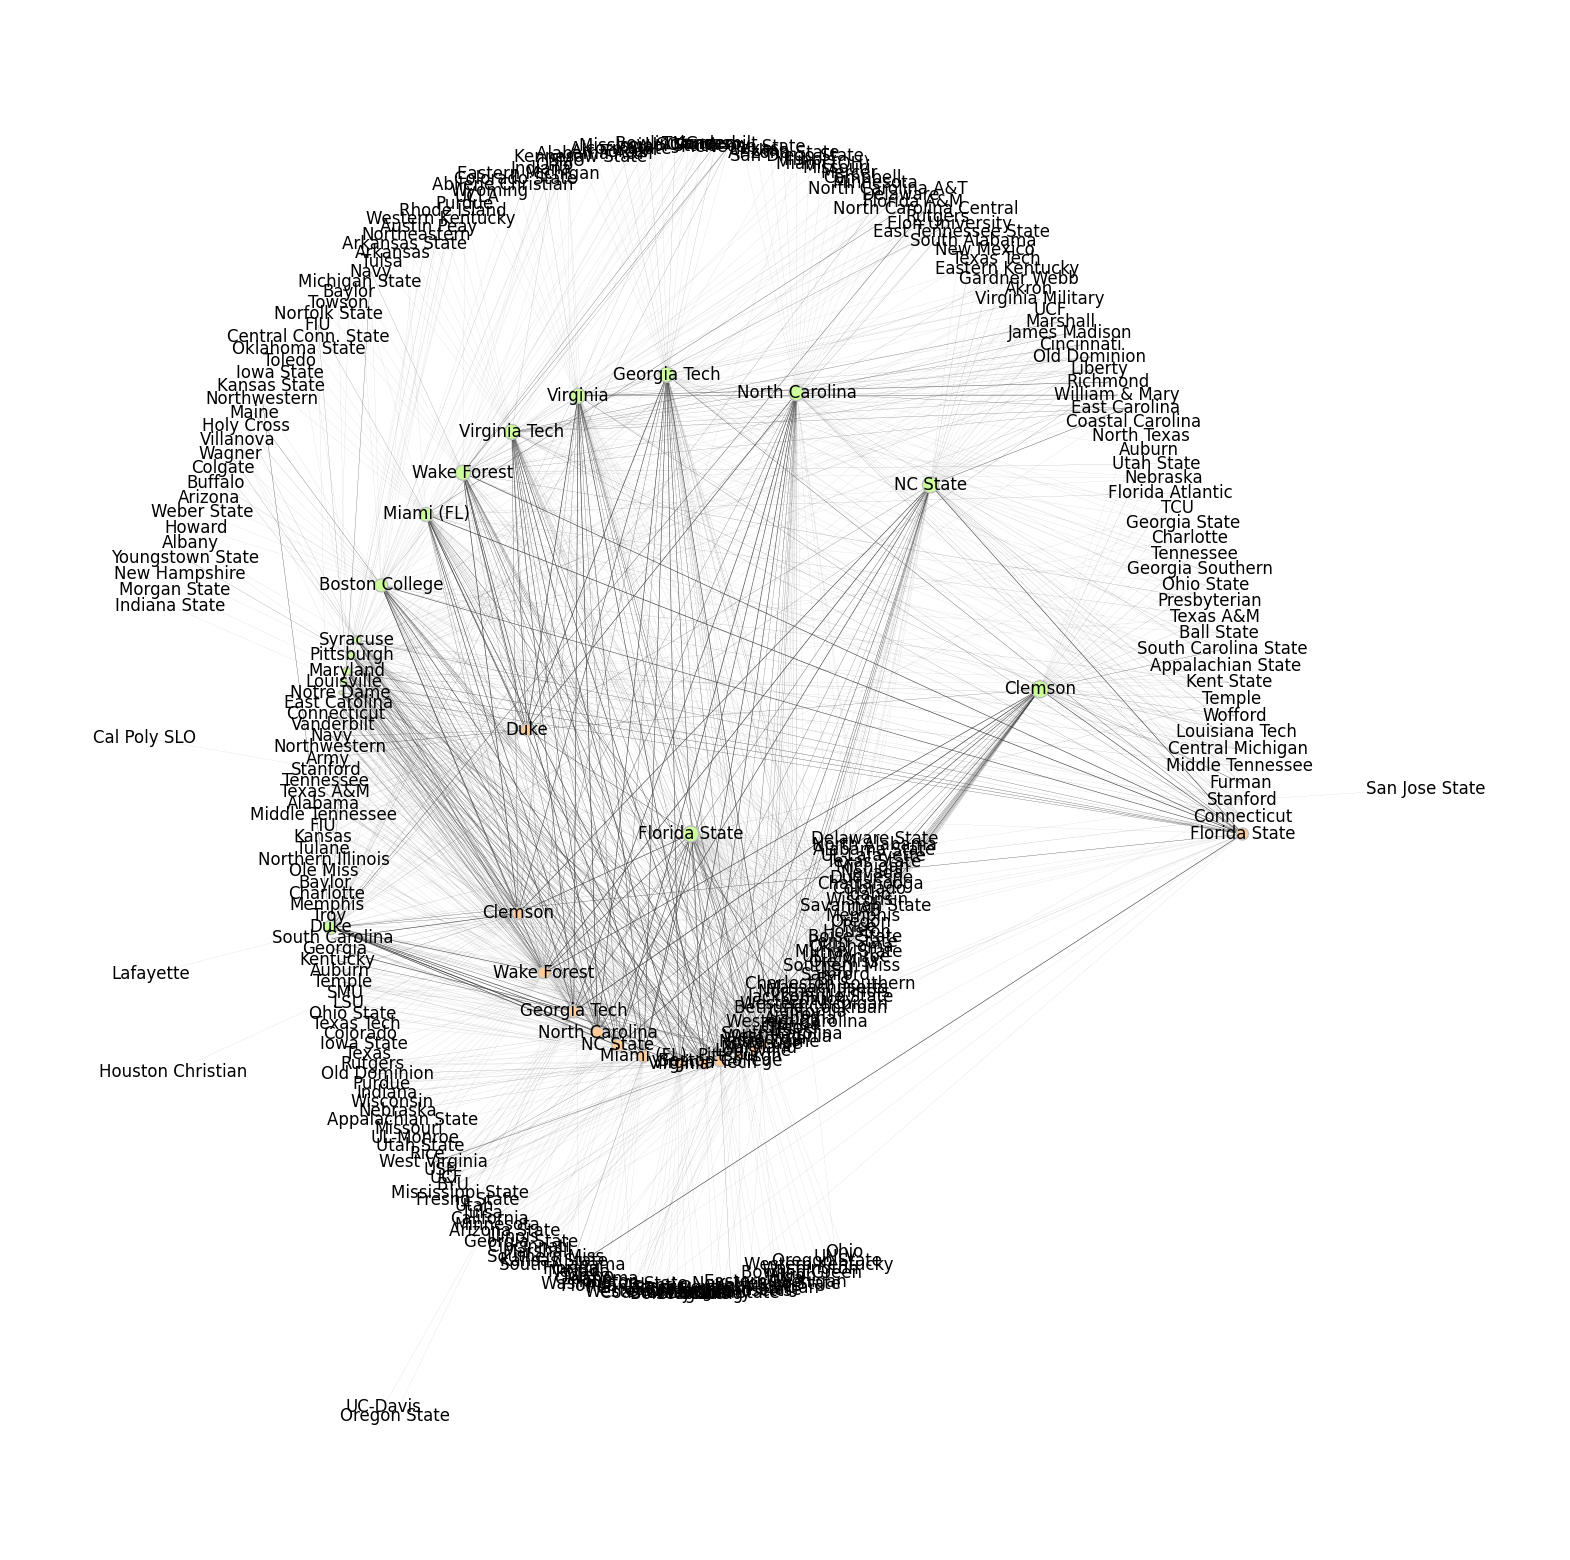

In [8]:
graphplot(g, ["home", "away"], sized=True)